# Winter 2022 Data Science Intern Challenge 

## By: Christopher "Kai" Painton
### Date: 9/15/21

Please complete the following questions, and provide your thought process/work. You can attach your work in a text file, link, etc. on the application page. Please ensure answers are easily visible for reviewers!


## Question 1: Given some sample data, write a program to answer the following: click here to access the required data set

On Shopify, we have exactly 100 sneaker shops, and each of these shops sells only one model of shoe. We want to do some analysis of the average order value (AOV). When we look at orders data over a 30 day window, we naively calculate an AOV of $3145.13. Given that we know these shops are selling sneakers, a relatively affordable item, something seems wrong with our analysis. 

## 1. Think about what could be going wrong with our calculation. Think about a better way to evaluate this data. 

Our first step should to be investigate the issues that are creating this unexpected, high AOV value

In [1]:
# We'll start by importating the necessary packages 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

In [2]:
# We'll read in the data and take a small look at the structure
shoe_data = pd.read_csv('DataChallengeShopify.csv')
shoe_data.head()

,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at
0,1,53,746,224,2,cash,2017-03-13 12:36:56
1,2,92,925,90,1,cash,2017-03-03 17:38:52
2,3,44,861,144,1,cash,2017-03-14 4:23:56
3,4,18,935,156,1,credit_card,2017-03-26 12:43:37
4,5,18,883,156,1,credit_card,2017-03-01 4:35:11


It looks like our data contains three id fields, the total cost of the order, the total items of the order, the payment method that was used, and when the transaction was created.  Let's take a look at the distribution of the total order amount.

In [3]:
# Gathers the intervals of the order amount for the shoe data
shoe_data['order_amount'].describe()

count      5000.000000
mean       3145.128000
std       41282.539349
min          90.000000
25%         163.000000
50%         284.000000
75%         390.000000
max      704000.000000
Name: order_amount, dtype: float64

The max amount from a sneaker order totals $704,000, significantly larger than our median and mean. This indicates that our data is right skewed and can lead to three possible conclusions: <br/>

1) This 704,000 purchase is a legitimate purchase and represents a high-end brand or large purchase volume <br/>
2) This is a fraudulent purchase  <br/>
3) There is a data encoding error and this was inputed as a mistake <br/>

Let's explore more of this purchase.

In [4]:
# Subsets the data for this specific purchase
anomly = shoe_data.loc[shoe_data['order_amount'] == 704000].sort_values('created_at').head(5)

anomly

,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at
520,521,42,607,704000,2000,credit_card,2017-03-02 4:00:00
4646,4647,42,607,704000,2000,credit_card,2017-03-02 4:00:00
60,61,42,607,704000,2000,credit_card,2017-03-04 4:00:00
15,16,42,607,704000,2000,credit_card,2017-03-07 4:00:00
2297,2298,42,607,704000,2000,credit_card,2017-03-07 4:00:00


It appears that there are multiple purchases of this nature, occurring regularly at 4 AM throughout the month of March.  While this reoccuring pattern is suspicious, we'd likely need more data (that isn't currently available) to conclude if this is fraudulent.  For now, let's explore if this is potentially a data error or real purchases.  

In [5]:
# Look into shop 42s order history 
shoe_data.loc[shoe_data['shop_id'] == 42, 'order_amount'].describe()

count        51.000000
mean     235101.490196
std      334860.641587
min         352.000000
25%         352.000000
50%         704.000000
75%      704000.000000
max      704000.000000
Name: order_amount, dtype: float64

In [6]:
# Get a count of all possible values for the store
shoe_data.loc[shoe_data['shop_id'] == 42, 'order_amount'].value_counts()

704000    17
352       15
704       13
1056       3
1408       2
1760       1
Name: order_amount, dtype: int64

It looks as if the lowest possible order value is $352, which is also equal to 704,000 divided by 2000, so it appears that the calculations are completed correctly. We'll move forward on this assumption that this is a common bulk purchase.  For example, this merchant could be selling to big-box retailers.  

Let's take a look if there are any daily factors that might be contributing to the changes in price, we'll look at plots with and without this outlier value.

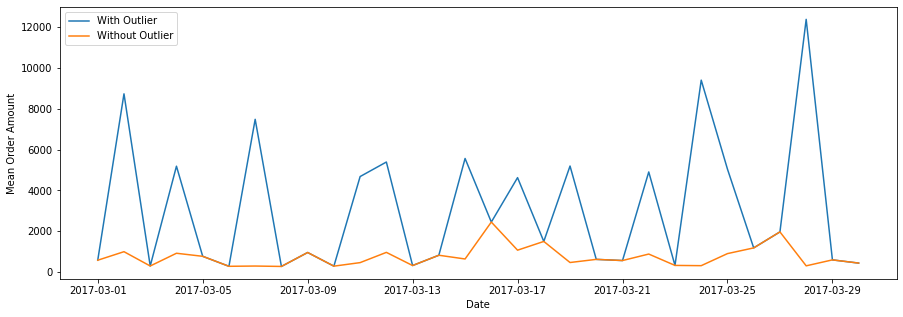

In [7]:
# Gather the date from the created_at field
shoe_data['date'] = pd.to_datetime(shoe_data['created_at']).dt.date

# Subset data without 704,000 orders and calculate order amount average by day
subset = shoe_data.loc[shoe_data['order_amount'] < 704000].groupby('date').agg({'order_amount':'mean'}).reset_index()

# Calculate Average order amount by day
shoe_data_day = shoe_data.groupby('date').agg({'order_amount':'mean'}).reset_index()

plt.figure(figsize = (15,5))

# Plots Original Order Amount data
sns.lineplot(data = shoe_data_day, x = 'date', y = 'order_amount')

# Plots Order Amount Averages by date without Outliers
sns.lineplot(data = subset, x = 'date', y = 'order_amount')
plt.legend(labels = ['With Outlier', 'Without Outlier'])
plt.ylabel('Mean Order Amount')
plt.xlabel('Date');

We can see here that this $704,000 purchase group is contributing heavily to influencing the AOV and thus makes it difficult to truly capture the mean spend for a pair of sneakers across these 100 different stores. There are some days (Example March 16th) with slight increases in average price (from the orange line) which might indicate other orders with high amount values. 

As a last sanity check, we can look at the distribution excluding this large purchase category.

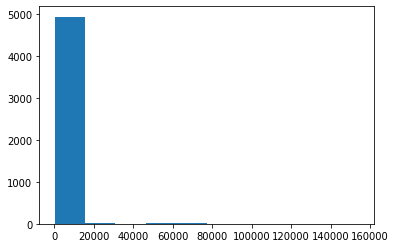

In [8]:
# Histogram of order values without outliers
plt.hist(shoe_data.loc[shoe_data['order_amount'] < 704000, 'order_amount']);

From this simple histogram, we can see that there are other outlier type orders that are also contributing to this large mean value. Let's adjust our histogram again, to consider only the middle 95% of purchases.  

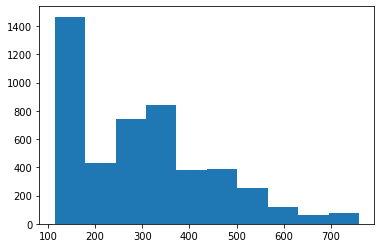

In [9]:
# Histogram of the middle 95% of orders completed
plt.hist(shoe_data.loc[(shoe_data.order_amount >= shoe_data.order_amount.quantile(0.025)) & 
              (shoe_data.order_amount <= shoe_data.order_amount.quantile(0.975)), 'order_amount']);

Here we can see that 95% of the purchases are falling within 100-800 dollars, so any metric that we report should capture this information., as it represents a large majority of the orders.

## 2. What metric would you report for this dataset?

One of the major flaws from the original approach is that mean is not a robust measure, meaning it is susceptible to outliers. With this in mind, there are a few alternative ways to approach reporting a new metric.

In [10]:
# Average Shoe Price
shoe_data['shoe_cost'] = shoe_data['order_amount'] / shoe_data['total_items']
shoe_data['shoe_cost'].mean()

387.7428

This average shoe price value could be useful for merchants trying to determine how to price their shoes against the competitors with Shopify stores. However, this approach is rather simple and naive as it doesn't consider order volume and could be susceptible to those large sneaker amounts.

In [11]:
# MOV, median order value
shoe_data['order_amount'].median()

284.0

In [12]:
shoe_data.groupby('payment_method')['order_amount'].median()

payment_method
cash           281
credit_card    288
debit          290
Name: order_amount, dtype: int64

This median gives a more appropriate view of the average order cost, as it considers the distribution of the data.  However, there are other metrics that we can use and package that might drive valuable insights.

In [13]:
# Quartile Range Approach
print(shoe_data['order_amount'].quantile(0.05))
print(shoe_data['order_amount'].quantile(0.95))

print(shoe_data['total_items'].quantile(0.05))
print(shoe_data['total_items'].quantile(0.95))

122.0
640.0
1.0
4.0


This quantile approach tells us the total amounts and items for the middle 90% of orders. Here we can see that 90% of orders fall between 122 to 640 dollars, with those customers typically ordering between 1 and 4 shoes.

However, I think we can package this data further, by segmenting merchants based on shoe cost and average item sizes to define median values for this specific groups.  This way we can group together merchants that are similar in nature and calculate their median order value as a more targeted approach. I'll use a scatterplot below to demonstrate (for visualizations purposes, I will limit the axis to draw a better view without the outliers): 

In [14]:
# Copy Data
segment = shoe_data.copy()

# Calculate the total for each shoe
segment['shoe_cost'] = segment['order_amount'] / segment['total_items']

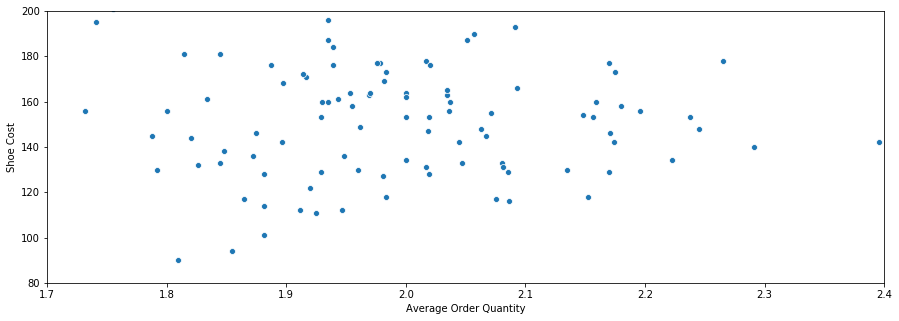

In [15]:
# Group by Shop and calculate average quantity of orders
subs = segment.groupby('shop_id').agg({'total_items':'mean', 'shoe_cost':'mean'})

plt.figure(figsize = (15,5));

# Plots Shoe cost by average order quantity
sns.scatterplot(data = subs, x = 'total_items', y = 'shoe_cost')
plt.xlim(1.7,2.4);
plt.ylim(80, 200);
plt.xlabel('Average Order Quantity');
plt.ylabel('Shoe Cost');

Here, we've plotted the sneaker cost to the average order quantity for each merchant.  We can see there is some variety in the cost of the sneaker and how many sneakers are purchased per order. Using this plot, we could define 4 quadrants grouping merchants based on if they have high or low order volume and if they offer cheap or expensive sneakers. I'll re-plot with these assigned groups based on shoe cost and average order quantity.

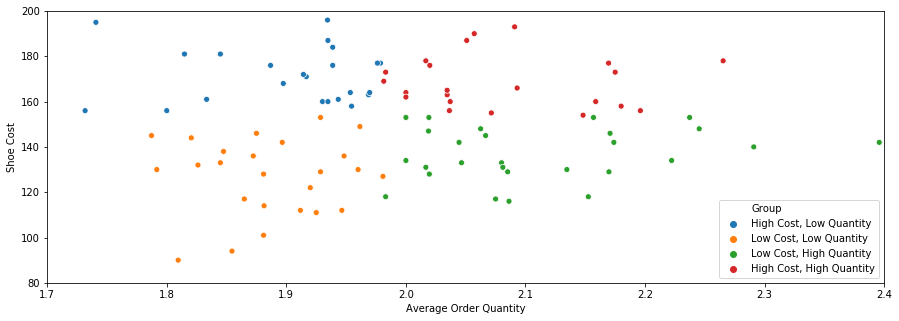

In [16]:
subs = segment.groupby('shop_id').agg({'total_items':'mean', 'shoe_cost':'mean'}).reset_index()

# Assigns merchants to groups based on quantile values 
subs['Group'] = np.where(subs['total_items'] < subs['total_items'].quantile(0.5), 
                np.where(subs['shoe_cost'] > subs['shoe_cost'].quantile(0.5), 'High Cost, Low Quantity',
                                                                              'Low Cost, Low Quantity'), 
                np.where(subs['shoe_cost'] > subs['shoe_cost'].quantile(0.5), 'High Cost, High Quantity',
                                                                              'Low Cost, High Quantity'))
                    

plt.figure(figsize = (15,5));
# Plots Shoe cost by average order quantity
sns.scatterplot(data = subs, x = 'total_items', y = 'shoe_cost', hue = 'Group')
plt.xlim(1.7,2.4);
plt.ylim(80, 200);
plt.xlabel('Average Order Quantity');
plt.ylabel('Shoe Cost');

Here we can clearly see four distinct groups: Low Cost, Low Quantity or Low Cost, High Quantity or High Cost, Low Quantity or High Cost, High Quantity.  These groups capture merchants that are similar based on their price points and order quantities.  With these defined groups, we can now use the original MOV calculation to find averages for these specific groups. 

In [17]:
# Merges with original data with groups and calculates MOV for grouped merchants
new_shoe_data = pd.merge(subs[['shop_id', 'Group']], shoe_data, on = 'shop_id')
new_shoe_data.groupby('Group')['order_amount'].median()

Group
High Cost, High Quantity    330
High Cost, Low Quantity     328
Low Cost, High Quantity     268
Low Cost, Low Quantity      224
Name: order_amount, dtype: int64

Using these four groups, we can have a more accurate representation of the median order cost, because not all merchants that sell shoes will be targeting the same market. This level of exploratory data analysis can be packaged and presented to merchants in a Consumer report that will help guide them into making better decisions for their business.

This represents one method and approach to segmenetation. Given more time, We could use a more advanced algorithm, like K-means, or choose to segment based on different criteria, or segment based on order dates or the customers. This segmentation approach will open many more oppurtunities to develop targeted KPIs that can inform our merchant population and help merchants make more informed decisions for their sites. 

## 3. What is its value?

By a simple cost per pair of shoe approach: **387.74 dollar cost per shoe**
    
A simple median order value approach (MOV): **284.0 dollars**

A simple range of values based on quantiles: **90% of orders fall between 122 - 640 dollars, purchasing on average between 1 to 4 pairs of shoes.**

Merchant Segmentation Approach: <br/>
High Cost, High Quantity Merchants MOV: **330 dollars <br/>**
High Cost, Low Quantity Merchants MOV: **328 dollars <br/>**
Low Cost, Low Quantity Merchants MOV: **224 dollars <br/>**
Low Cost, High Quantity Merchants: MOV: **268 dollars <br/>**

## Question 2: For this question you’ll need to use SQL. Follow this link to access the data set required for the challenge. Please use queries to answer the following questions. Paste your queries along with your final numerical answers below.

1. How many orders were shipped by Speedy Express in total?

**There were 54 orders shipped by Speedy Express in total.**

```SQL
SELECT s.shipperName, COUNT(o.orderID) AS TotalOrders
FROM Orders o
LEFT JOIN Shippers s ON s.ShipperID = o.ShipperID
WHERE s.shipperName = 'Speedy Express'
GROUP BY s.shipperName
```

2. What is the last name of the employee with the most orders?

**Peacock has the most orders with 40.**

```SQL
SELECT e.EmployeeID, e.LastName, COUNT(o.OrderID) AS TotalOrders
FROM Orders o
LEFT JOIN Employees e ON e.EmployeeID = o.EmployeeID
GROUP BY e.EmployeeID, e.LastName
ORDER BY COUNT(o.OrderID) DESC
LIMIT 1
```

**W3Schools interface doesn't work with Common Table Expressions, but generally I would solve this query in this way (in the edge case that two employees had 40 orders):**
```SQL
WITH cte AS (SELECT e.EmployeeID, e.LastName, COUNT(o.OrderID) AS TotalOrders
FROM Orders o
LEFT JOIN Employees e ON e.EmployeeID = o.EmployeeID
GROUP BY e.EmployeeID, e.LastName)
SELECT LastName, TotalOrders
FROM cte
WHERE TotalOrders = (SELECT MAX(TotalOrders) FROM cte)
```

3. What product was ordered the most by customers in Germany?

If this question is referring to each time the product was apart of an individual order then the answer would be: 

**Gorgonzola Telino with 5 different orders**

```SQL
SELECT p.ProductName, COUNT(o.OrderID) AS TotalOrders
FROM ( ( ( Orders o LEFT JOIN Customers c on o.CustomerID = c.CustomerID )
     	  LEFT JOIN OrderDetails od on od.OrderID = o.OrderID )
    	  LEFT JOIN Products p on p.ProductID = od.ProductID )
WHERE c.Country = 'Germany'
GROUP BY p.ProductName
ORDER BY COUNT(o.OrderID) DESC
LIMIT 1
```

However, if this question is referring to the product that had the highest total quantity then the answer would be: 

**Boston Crab Meat with 160 total units purchased**

```SQL
SELECT p.ProductName, SUM(od.Quantity) AS TotalQuantity
FROM ( ( ( Orders o LEFT JOIN Customers c on o.CustomerID = c.CustomerID )
     	  LEFT JOIN OrderDetails od on od.OrderID = o.OrderID )
    	  LEFT JOIN Products p on p.ProductID = od.ProductID )
WHERE c.Country = 'Germany'
GROUP BY p.ProductName
ORDER BY SUM(od.Quantity) DESC
LIMIT 1
```

The W3Schools Interface isn't allowing me to complete multiple joins in my traditional way (Postgres SQL), generally I would explicitly state each LEFT JOIN and alias the tables. Additionally, like the issue mentioned above in Question 2, I would use common table expressions and the last WHERE statement with subqueries finding the MAX to solve this problem.